# Tutorial: Understanding PLUMED and collective variables

Getting tutorial files using command line 
```
wget https://raw.githubusercontent.com/intbio/MolModEdu/master/PLUMED/plumed_intro.ipynb
wget https://raw.githubusercontent.com/intbio/MolModEdu/master/PLUMED/xvg_plot.py
wget https://raw.githubusercontent.com/intbio/MolModEdu/master/PLUMED/funcs.py

```

In this tutorial we will learn how to launch Gromacs with PLUMED and define collective variables (CVs).
We will use a short peptide as a test system.

- Full PLUMED documentation is here https://plumed.github.io/doc-v2.5/user-doc/html/_syntax.html
- For full Gromacs manual, see here http://manual.gromacs.org



## Step 1: Getting, a short-helix structure
We will get a short alpha-helix from  H4-histone.

In [1]:
%%bash --out output --err error
wget https://files.rcsb.org/view/1KX5.pdb

In [8]:
import MDAnalysis as mda
nucl=mda.Universe("1KX5.pdb")

sel_text="(segid B and (resid 24:29 or (resid 23 and name C O CA) or (resid 30 and name N CA)))"
h4helix=nucl.select_atoms(sel_text)


nucl.select_atoms("segid B and resid 23").residues.resnames='ACE'
nucl.select_atoms("segid B and resid 23 and name CA").atoms.names='CH3'
nucl.select_atoms("segid B and resid 30").residues.resnames='NME'
nucl.select_atoms("segid B and resid 30 and name CA").atoms.names='CH3'


nucl.trajectory.remarks=[]
nucl.trajectory.compound=[]
nucl.trajectory.header=['H4 helix']

#print(dimer.atoms.names)
h4helix.write("sys.pdb")

In [9]:
import nglview as nv
a=nv.show_mdanalysis(h4helix,gui=False)
a.add_representation(selection='protein',repr_type='licorice')
a.render_image()
a

NGLWidget()

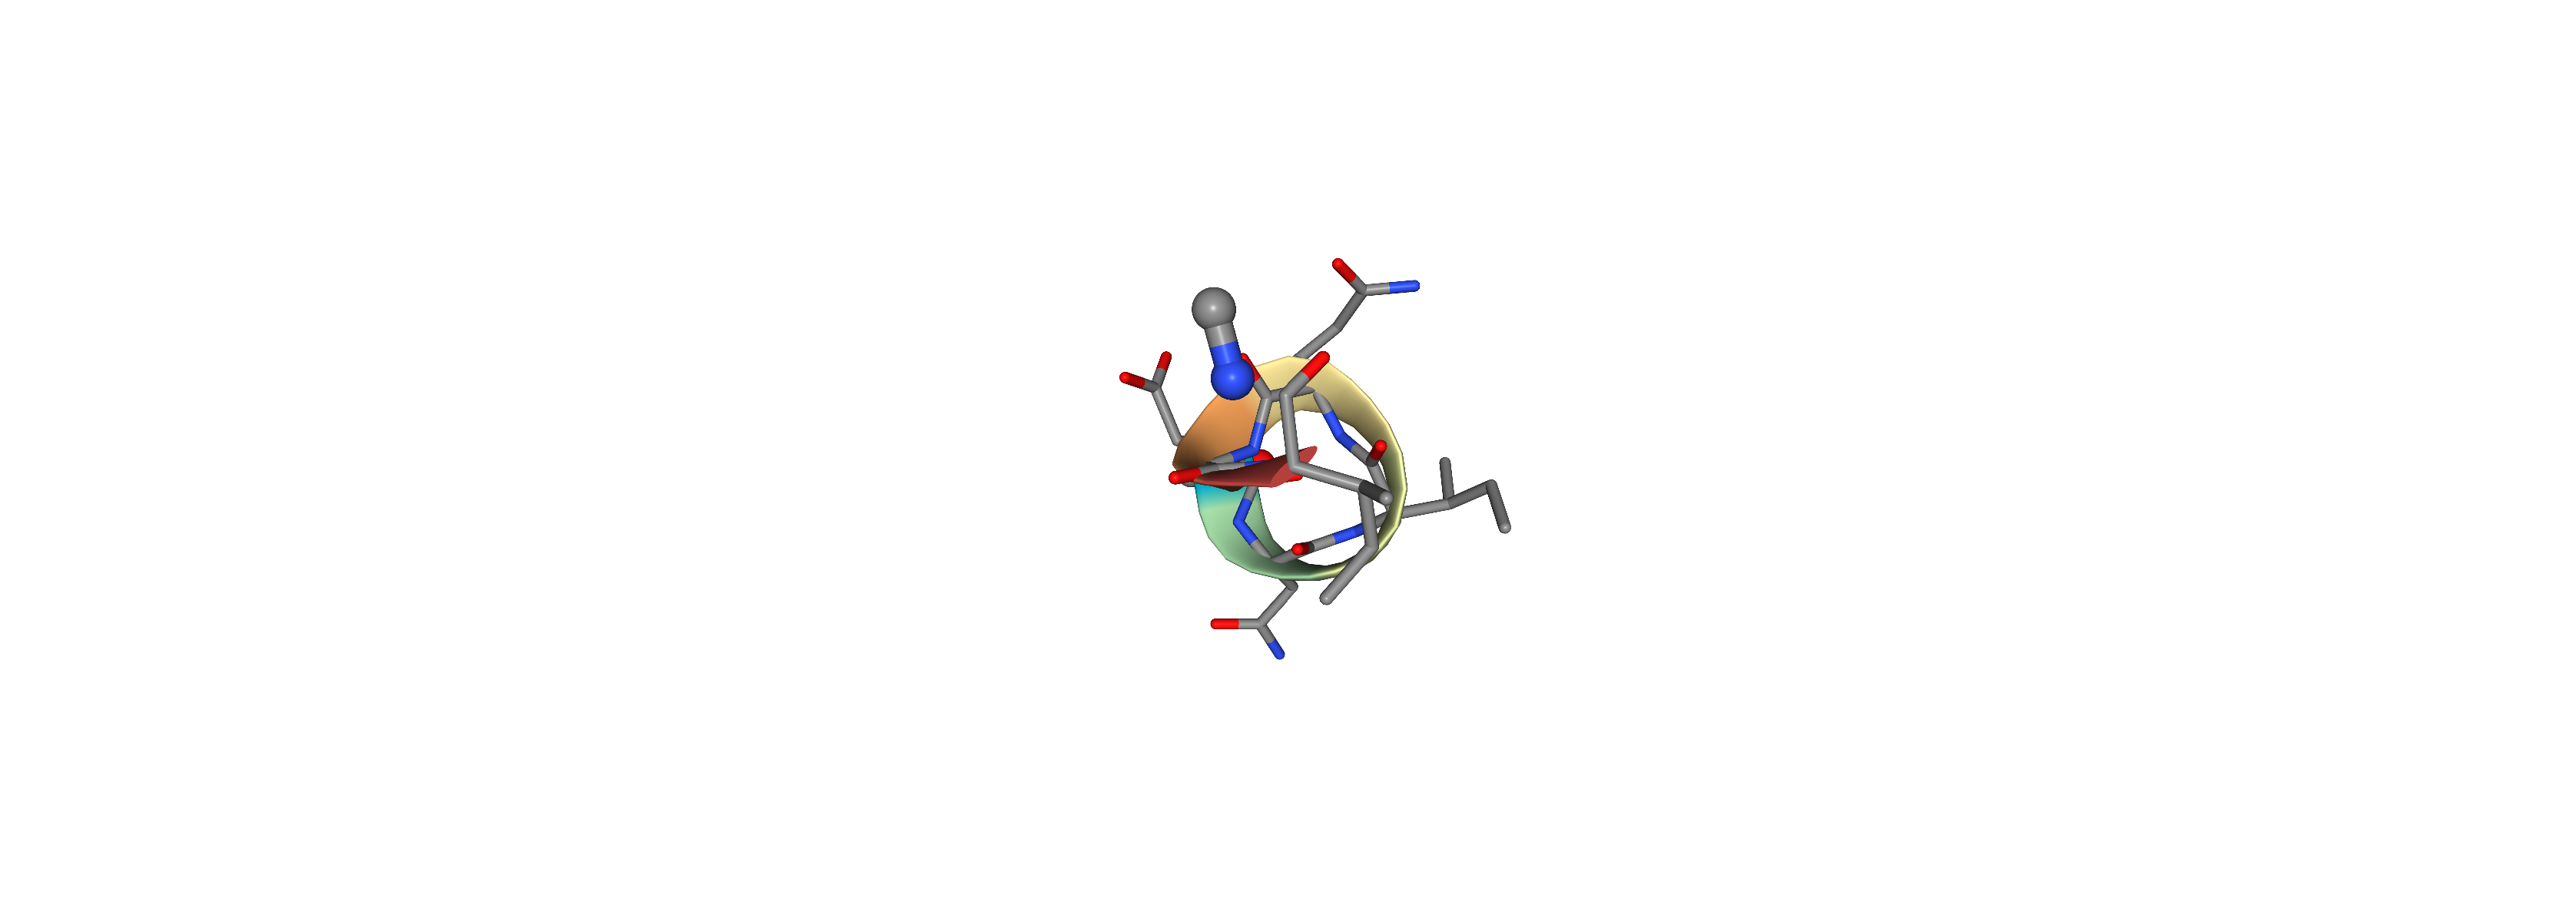

In [5]:
a._display_image()

## Step 2. Prepair system for simulations in Gromacs.
It is expected that you have completed the Gromacs tutorial and understand following steps without explanation.


In [5]:
#First get mdp files.
!rm -rf MDProtocols
from funcs import get_files_from_git
prot_url="https://api.github.com/repos/intbio/gmx_protocols/contents/amber_quick"
get_files_from_git(prot_url,'MDProtocols/')

In [47]:
!gmx pdb2gmx -f sys.pdb -o init.pdb -p topol.top -water tip3p -ff amber99sb-ildn >/dev/null 2>&1
#Comment out >/dev/null 2>&1 if you see errors or to see output of the command
#Same in all commands below, the output is supressed to save space

In [48]:
#First put a system in a periodic box, with 1 nm distance to the walls (-d), centered in the box (-c)
!gmx editconf -d 1 -c -f init.pdb -o init_box.pdb >/dev/null 2>&1

In [49]:
#Now to the solvation, note, the topology file will be updated to reflect the added water molecules.
!gmx solvate -cp init_box.pdb -cs spc216.gro -o init_solv.pdb -p topol.top >/dev/null 2>&1

In [50]:
#Let's look at the protein in a water box.
import nglview as nv
a=nv.show_structure_file('init_solv.pdb')
a.add_representation('licorice')
a

NGLWidget()

In [51]:
!gmx grompp -f MDProtocols/ions.mdp -c init_solv.pdb -p topol.top -o ions.tpr -maxwarn 1 >/dev/null 2>&1

And now run genions http://manual.gromacs.org/documentation/current/onlinehelp/gmx-genion.html

In [52]:
%%bash
gmx genion -s ions.tpr -o init_solv_ions.pdb -p topol.top -conc 0.150 -neutral <<! >/dev/null 2>&1
SOL
!

In [53]:
#Let's look at the protein in a water box with ions.
import nglview as nv
a=nv.show_structure_file('init_solv_ions.pdb')
a.add_representation('licorice')
a.add_representation('spacefill',selection='CL', color='green')
a.add_representation('spacefill',selection='NA', color='magenta')
a

NGLWidget()

The `grompp` comand packs topology together with mdp file into a .tpr file - the sole file needed to start minimization/simulation.
See details here http://manual.gromacs.org/documentation/current/onlinehelp/gmx-grompp.html

In [54]:
!gmx grompp -f MDProtocols/minim.mdp -c init_solv_ions.pdb -p topol.top -o minim.tpr -r init_solv_ions.pdb >/dev/null 2>&1

Now let's run the minimization, this may take a while ...

In [55]:
!gmx mdrun -nt 10 -deffnm minim >/dev/null 2>&1 # nt is the number of threads, choose less than the number of CPUs you have

In [56]:
!gmx grompp -f MDProtocols/equil.mdp -c minim.gro -p topol.top -o equil.tpr -r init_solv_ions.pdb >/dev/null 2>&1

In [59]:
!gmx mdrun -nt 10 -deffnm equil >/dev/null 2>&1  # nt is the number of threads, choose less than the number of CPUs you have

In [60]:
#Let's see atoms moving!
#Note, due to periodic boundary conditions molecule bonds may look stretched!
import nglview as nv
import MDAnalysis as mda

MD=mda.Universe('init_solv_ions.pdb','equil.xtc')
a=nv.show_mdanalysis(MD)
a.add_representation('licorice',selection='protein')
a.add_representation('spacefill',selection='CL', color='green')
a.add_representation('spacefill',selection='NA', color='magenta')
a.camera = 'orthographic'
a

/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/MDAnalysis/coordinates/XDR.py:195: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


NGLWidget(count=101)

Finally, let's prepare the 0.1 ns production file.

In [61]:
!gmx grompp -f MDProtocols/prod.mdp -c equil.gro -p topol.top -o prod.tpr -r init_solv_ions.pdb >/dev/null 2>&1

## Step 3. Now we are ready to explore PLUMED
- Invoking GROMACS to use PLUMED is as ```gmx mdrun -plumed plumed.dat```
- We'll need to make a plumed.dat file with commands for PLUMED

## Step 3.1. Let's start with simply reporting distance between the ends of our helix
The code should look as
```
d1: DISTANCE ATOMS=1,2
PRINT ARG=d1 FILE=colvar STRIDE=10
```
https://plumed.github.io/doc-v2.5/user-doc/html/_d_i_s_t_a_n_c_e.html
But we need to specify atom numbers, this can be done by MDanalysis code. Let's do it.

In [62]:
import MDAnalysis as mda
import MDAnalysis.analysis.hbonds
import MDAnalysis.analysis.distances

#Let's load a structure with hydrogens, assumed the numbering is the same with full system, since water and ions are added to the end.
nucl=mda.Universe("init_box.pdb")

sel_end1="(segid B and resid 24 and name CA)"
sel_end2="(segid B and resid 29 and name CA)"


E1=nucl.select_atoms(sel_end1)

E2=nucl.select_atoms(sel_end2)

d=MDAnalysis.analysis.distances.dist(E1,E2)[2][0]/10.
print("Initinal distance=",d,"nm")

e1=E1.atoms[0].id
e2=E2.atoms[0].id
print("Atom1id=",e1,"Atom2id=",e2,"\n ----")

#Now let's write a plumed.dat file
!echo "d1: DISTANCE ATOMS=$e1,$e2" >plumed.dat
!echo "PRINT ARG=d1 FILE=colvar.dat STRIDE=10" >>plumed.dat
!cat plumed.dat

Initinal distance= 0.8285016256496333 nm
Atom1id= 9 Atom2id= 78 
 ----
d1: DISTANCE ATOMS=9,78
PRINT ARG=d1 FILE=colvar.dat STRIDE=10


In [63]:
!gmx mdrun -nt 10 -deffnm prod -plumed plumed.dat >/dev/null 2>&1 # nt is the number of threads, choose less than the number of CPUs you have

In [64]:
#Let's see atoms moving!
#Note, due to periodic boundary conditions molecule bonds may look stretched!
import nglview as nv
import MDAnalysis as mda

MD=mda.Universe('init_solv_ions.pdb','prod.xtc')
a=nv.show_mdanalysis(MD)
a.add_representation('licorice',selection='protein')
a.add_representation('spacefill',selection='CL', color='green')
a.add_representation('spacefill',selection='NA', color='magenta')
a.camera = 'orthographic'
a

NGLWidget(count=11)

NOTE: some bonds get overstretched due to atoms crossing periodic boundary conditions, but by default the distance is computed taking into account periodic boundary conditions. (BUT not the cartesion components of it, see manual)

In [65]:
#here is the file that we get 
!head colvar.dat

#! FIELDS time d1
 0.000000 0.835698
 0.020000 0.846667
 0.040000 0.856927
 0.060000 0.865891
 0.080000 0.847344
 0.100000 0.842226
 0.120000 0.848550
 0.140000 0.855939
 0.160000 0.842911


Labels found: ['time', 'd1']


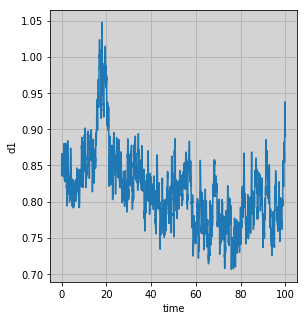

array([[0.00000000e+00, 8.35698000e-01],
       [2.00000000e-02, 8.46667000e-01],
       [4.00000000e-02, 8.56927000e-01],
       ...,
       [9.99600050e+01, 8.91863000e-01],
       [9.99800050e+01, 8.91765000e-01],
       [1.00000005e+02, 8.90632000e-01]])

In [66]:
from importlib import reload 
import funcs
reload(funcs)
from funcs import plot_plumed
import numpy as np
%matplotlib inline
plot_plumed('colvar.dat',figsize=(5,5))

## Step 3.2. Several collective variables at a time.
Let's see how we can do two distances.
These can be output to two files with two PRINT statements, but let's try to output in one file.
```
d1: DISTANCE ATOMS=9,78
d2: DISTANCE ATOMS=10,79
PRINT ARG=d1,d2 FILE=colvar.dat STRIDE=10
```


In [67]:
#Now let's write a plumed.dat file
!echo "d1: DISTANCE ATOMS=9,78" >plumed.dat
!echo "d2: DISTANCE ATOMS=40,50" >>plumed.dat
!echo "PRINT ARG=d1,d2 FILE=colvar.dat STRIDE=10" >>plumed.dat
!cat plumed.dat

d1: DISTANCE ATOMS=9,78
d2: DISTANCE ATOMS=40,50
PRINT ARG=d1,d2 FILE=colvar.dat STRIDE=10


In [72]:
!gmx mdrun -nt 10 -deffnm prod -plumed plumed.dat >/dev/null 2>&1 # nt is the number of threads, choose less than the number of CPUs you have

In [73]:
!head colvar.dat

#! FIELDS time d1 d2
 0.000000 0.835698 0.424041
 0.020000 0.846667 0.433207
 0.040000 0.856927 0.417795
 0.060000 0.865891 0.403746
 0.080000 0.847344 0.389449
 0.100000 0.842226 0.402771
 0.120000 0.848550 0.416601
 0.140000 0.855939 0.422868
 0.160000 0.842911 0.430196


Labels found: ['time', 'd1', 'd2']


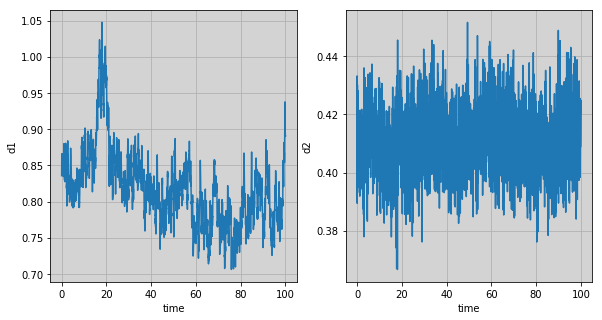

In [74]:
from importlib import reload 
import funcs
reload(funcs)
from funcs import plot_plumed
import numpy as np
%matplotlib inline
data=plot_plumed('colvar.dat',figsize=(5,5))

Text(0, 0.5, 'd2, nm')

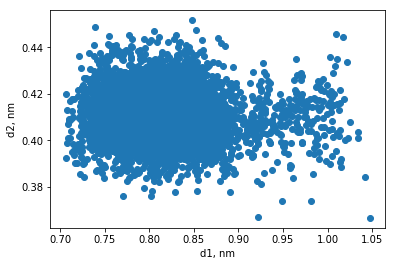

In [75]:
#Let's make a 2D plot
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
plt.plot(data[:,1],data[:,2],'o')
plt.xlabel('d1, nm')
plt.ylabel('d2, nm')

We see that one of the CVs is behaving in a stepwise manner, this is a sidechain of a residue rotating.


## Step 3.5 Virtual atoms
Let's define centers of mass 
NOTE: The PBC treatmeat is done automatically since PLUMED 2.2, by considering the ordered list of atoms and rebuilding the molecule using a procedure that is equivalent to that done in WHOLEMOLECULES.
Now on we will compress the code to leave only output.

d1: DISTANCE ATOMS=9,78
c1: COM ATOMS=40
c2: COM ATOMS=50
d2: DISTANCE ATOMS=c1,c2
PRINT ARG=d1,d2 FILE=colvar.dat STRIDE=10
Labels found: ['time', 'd1', 'd2']


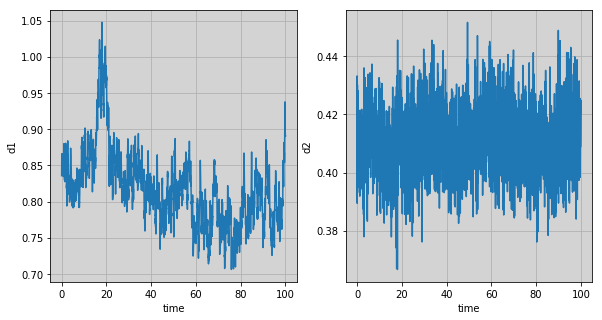

In [76]:
!echo "d1: DISTANCE ATOMS=9,78" >plumed.dat
!echo "c1: COM ATOMS=40" >>plumed.dat
!echo "c2: COM ATOMS=50" >>plumed.dat
!echo "d2: DISTANCE ATOMS=c1,c2" >>plumed.dat
!echo "PRINT ARG=d1,d2 FILE=colvar.dat STRIDE=10" >>plumed.dat
!cat plumed.dat
!gmx mdrun -nt 10 -deffnm prod -plumed plumed.dat 2> /dev/null # nt is the number of threads, choose less than the number of CPUs you have
from funcs import plot_plumed
%matplotlib inline
data=plot_plumed('colvar.dat',figsize=(5,5))

## Step 3.4. Angles 
 - https://plumed.github.io/doc-v2.5/user-doc/html/_a_n_g_l_e.html
 - https://plumed.github.io/doc-v2.5/user-doc/html/_t_o_r_s_i_o_n.html

d1: DISTANCE ATOMS=9,78
a1: ANGLE ATOMS=1,50,100
t1: TORSION ATOMS=1,25,50,100
PRINT ARG=d1,a1,t1 FILE=colvar.dat STRIDE=10
Labels found: ['time', 'd1', 'a1', 't1']


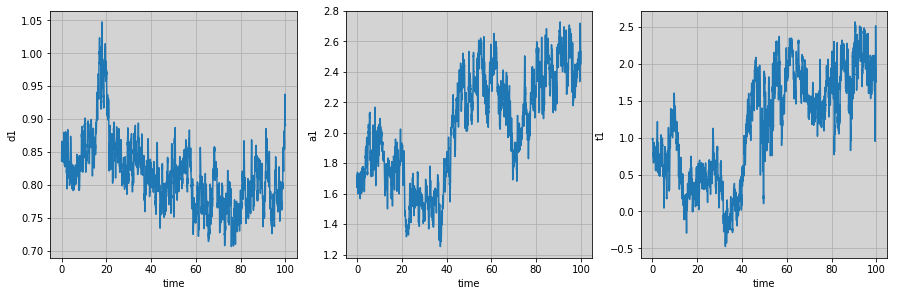

In [77]:
!echo "d1: DISTANCE ATOMS=9,78" >plumed.dat
!echo "a1: ANGLE ATOMS=1,50,100" >>plumed.dat
!echo "t1: TORSION ATOMS=1,25,50,100" >>plumed.dat
# this is an alternative, equivalent, definition:
# t: TORSION VECTOR1=2,1 AXIS=2,3 VECTOR2=3,4
!echo "PRINT ARG=d1,a1,t1 FILE=colvar.dat STRIDE=10" >>plumed.dat
!cat plumed.dat
!gmx mdrun -nt 10 -deffnm prod -plumed plumed.dat 2> /dev/null # nt is the number of threads, choose less than the number of CPUs you have
from funcs import plot_plumed
%matplotlib inline
data=plot_plumed('colvar.dat',figsize=(5,5))

## Step 3.5. Use of a reference structure to define parameters
 - https://plumed.github.io/doc-v2.5/user-doc/html/_t_o_r_s_i_o_n.html
 - Here, @phi-3 tells plumed that you would like to calculate the ϕ angle in the third residue of the protein. Similarly @psi-4 tells plumed that you want to calculate the ψ angle of the fourth residue of the protein.

MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb
t1: TORSION ATOMS=@phi-24
t2: TORSION ATOMS=@psi-24
t3: TORSION ATOMS=@omega-24
t4: TORSION ATOMS=@chi1-24
PRINT ARG=t1,t2,t3,t4 FILE=colvar.dat STRIDE=10
Labels found: ['time', 't1', 't2', 't3', 't4']


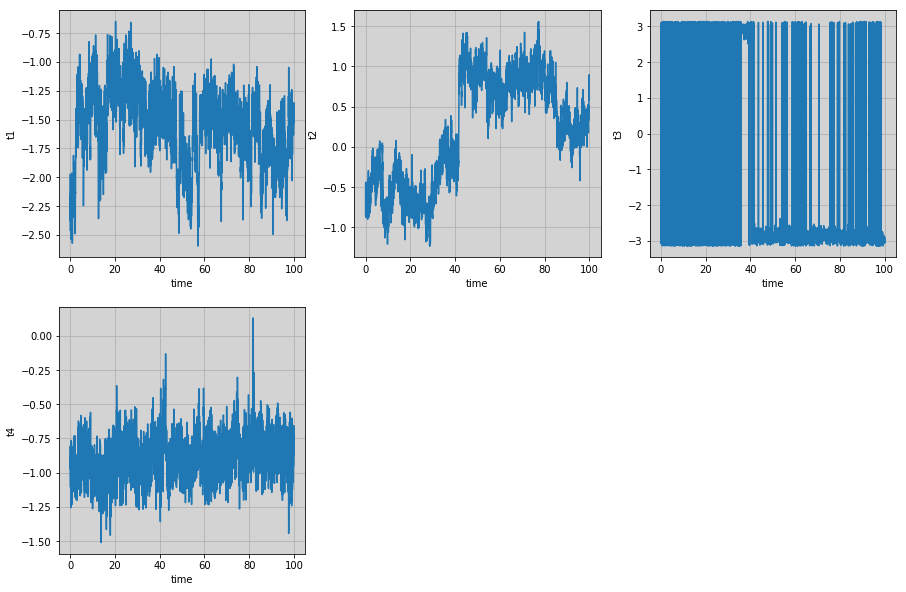

In [78]:
!echo "MOLINFO MOLTYPE=protein STRUCTURE=init_box.pdb" >plumed.dat
!echo "t1: TORSION ATOMS=@phi-24" >>plumed.dat
!echo "t2: TORSION ATOMS=@psi-24" >>plumed.dat
!echo "t3: TORSION ATOMS=@omega-24" >>plumed.dat
!echo "t4: TORSION ATOMS=@chi1-24" >>plumed.dat
!echo "PRINT ARG=t1,t2,t3,t4 FILE=colvar.dat STRIDE=10" >>plumed.dat
!cat plumed.dat
!gmx mdrun -nt 10 -deffnm prod -plumed plumed.dat 2> /dev/null # nt is the number of threads, choose less than the number of CPUs you have
from funcs import plot_plumed
%matplotlib inline
data=plot_plumed('colvar.dat',figsize=(5,5))

## Step 3.5. RMSD with reference PDB
- https://plumed.github.io/doc-v2.5/user-doc/html/_r_m_s_d.html
- https://plumed.github.io/doc-v2.5/user-doc/html/_d_r_m_s_d.html
- https://plumed.github.io/doc-v2.3/user-doc/html/_w_h_o_l_e_m_o_l_e_c_u_l_e_s.html

DRMSD is an alternative to classical RMSD which is a faster metric, but we will proceed with classic.
A reference PDB file should be defined:
Notice that there are sets of weights: w′ and w. The first is used to calculate the position of the center of mass (so it determines how the atoms are aligned). Meanwhile, the second is used when calculating how far the atoms have actually been displaced. These weights are assigned in the reference configuration that you provide as input (i.e. the appear in the input file to this action that you set using REFERENCE=whatever.pdb).

The pdb input file should also contain the values of w and w′. In particular, the OCCUPANCY column (the first column after the coordinates) is used provides the values of w′ that are used to calculate the position of the center of mass. The BETA column (the second column after the Cartesian coordinates) is used to provide the w values which are used in the the calculation of the displacement. 

We'll need to make a reference PDB file with occupancy and B-factor columns set up.

WARNING: The molecule used for RMSD calculation should be whole (both atoms used in alignment and in displacement calculation). In case it is broken by the host MD code, please use WHOLEMOLECULES to reconstruct it before RMSD calculation.


In [79]:
import MDAnalysis as mda
import numpy as np
nucl=mda.Universe("init_box.pdb") # This already has hydrogens, and atom naming should be correct.

u=nucl.select_atoms("all")
u.occupancies = 1 * np.ones(u.n_atoms)
u.tempfactors = 1 * np.ones(u.n_atoms)

#print(dimer.atoms.names)
u.write("sysH_ref_rmsd.pdb")

WHOLEMOLECULES ENTITY0=1-100
r1: RMSD REFERENCE=sysH_ref_rmsd.pdb TYPE=OPTIMAL
PRINT ARG=r1 FILE=colvar.dat STRIDE=10
Labels found: ['time', 'r1']


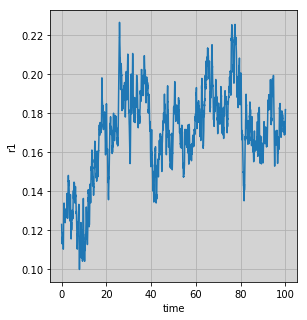

In [80]:
!echo "WHOLEMOLECULES ENTITY0=1-100" >plumed.dat
!echo "r1: RMSD REFERENCE=sysH_ref_rmsd.pdb TYPE=OPTIMAL" >>plumed.dat
!echo "PRINT ARG=r1 FILE=colvar.dat STRIDE=10" >>plumed.dat
!cat plumed.dat
!gmx mdrun -nt 10 -deffnm prod -plumed plumed.dat 2> /dev/null # nt is the number of threads, choose less than the number of CPUs you have
from funcs import plot_plumed
%matplotlib inline
data=plot_plumed('colvar.dat',figsize=(5,5))

WHOLEMOLECULES ENTITY0=1-100
r1: RMSD REFERENCE=sysH_ref_rmsd.pdb TYPE=SIMPLE
PRINT ARG=r1 FILE=colvar.dat STRIDE=10
Labels found: ['time', 'r1']


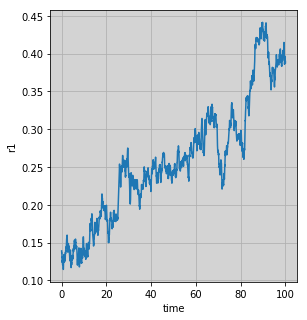

In [81]:
#Note, TYPE=SIMPLE will not remove the rotations
!echo "WHOLEMOLECULES ENTITY0=1-100" >plumed.dat
!echo "r1: RMSD REFERENCE=sysH_ref_rmsd.pdb TYPE=SIMPLE" >>plumed.dat
!echo "PRINT ARG=r1 FILE=colvar.dat STRIDE=10" >>plumed.dat
!cat plumed.dat
!gmx mdrun -nt 10 -deffnm prod -plumed plumed.dat 2> /dev/null # nt is the number of threads, choose less than the number of CPUs you have
from funcs import plot_plumed
%matplotlib inline
data=plot_plumed('colvar.dat',figsize=(5,5))

## Step 3.6. Secondary structure content
- https://plumed.github.io/doc-v2.3/user-doc/html/_a_l_p_h_a_r_m_s_d.html


MOLINFO STRUCTURE=init_box.pdb
WHOLEMOLECULES ENTITY0=1-100
a1: ALPHARMSD RESIDUES=all TYPE=DRMSD R_0=0.08
PRINT ARG=a1 FILE=colvar.dat STRIDE=10
Labels found: ['time', 'a1']


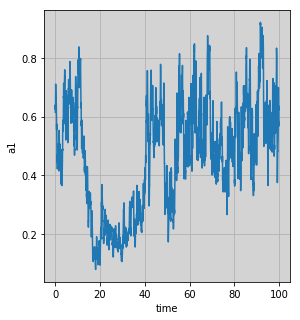

In [82]:
#Alpha content
!echo "MOLINFO STRUCTURE=init_box.pdb" >plumed.dat
!echo "WHOLEMOLECULES ENTITY0=1-100" >>plumed.dat
!echo "a1: ALPHARMSD RESIDUES=all TYPE=DRMSD R_0=0.08" >>plumed.dat
!echo "PRINT ARG=a1 FILE=colvar.dat STRIDE=10" >>plumed.dat
!cat plumed.dat
!gmx mdrun -nt 10 -deffnm prod -plumed plumed.dat 2> /dev/null # nt is the number of threads, choose less than the number of CPUs you have
from funcs import plot_plumed
%matplotlib inline
data=plot_plumed('colvar.dat',figsize=(5,5))

In [83]:
## Other commands

In [84]:
# Auxilary
# Clear files
!rm \#*
!rm bck*